<a href="https://colab.research.google.com/github/GarganoNicolas/timeSeries1_codificandobits/blob/main/timeSeries1_codificandobits_lstm_timeseries_practice_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PRACTICE OF HYPERPARAMETERS

## Contenido

1. [Introducción](#scrollTo=wHQ1yXwrk6CN)
2. [El set de datos](#scrollTo=QDm0J6L-7rGI&line=1&uniqifier=1)
3. [El problema a resolver](#scrollTo=CBJV_YRvj5CZ&line=1&uniqifier=1)
4. [Lectura del set de datos](#scrollTo=Es6L4nEckb3S&line=1&uniqifier=1)
5. 🔥🔥[Análisis detallado de la variable tiempo](#scrollTo=6XaUeEUsM0Gf)🔥🔥
5. [*Feature engineering*](#scrollTo=Ex5fnN-tMD7c&line=25&uniqifier=1)
6. 🔥🔥[Pre-procesamiento](#scrollTo=vd5lyqNrlfFg)🔥🔥
7. [Creación y entrenamiento del modelo](#scrollTo=016D9eVw3Beb)
8. [Desempeño del modelo](#scrollTo=ZkI9vr5S69i_)
9. [Predicciones con el modelo entrenado](#scrollTo=fvqk4f8L3aXE&line=1&uniqifier=1)
10. [Conclusiones y sugerencias](#scrollTo=0AFY2trj_KLo&line=1&uniqifier=1)

## 1. Introducción

# Luego de ver y hacer correr todos los ipynb, es tiempo de probar el modelo cambiando los hyperparametros y tomar nota de esos cambios

##2. El set de datos

Recordemos que estamos usando el  [weather dataset](https://www.bgc-jena.mpg.de/wetter/weather_data.html), un set de datos que contiene el registro histórico de 14 diferentes variables climáticas en el período entre 2009 y 2015.

En el segundo video de la serie realizamos el análisis exploratorio del dataset y realizamos este pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora



##3. El problema a resolver

Elaborar una Red LSTM que prediga la temperatura con el mayor acierto posible usando diferentes modelos de LSTM y diferentes parametros

Voy a conservar todo lo realizado en el anterior colab sobre el procesamiento de las columnas pero modificando los hyperparametros y las variables que le introduzco al modelo para ver como se comporta

##4. Lectura del set de datos

El dataset implementado en el es procesado en el siguiendo enlace [segundo video de la serie](https://youtu.be/R8MEPGn9sFI), sobre el cual Miguel Sotaquira de codificando bits ha hecho un pre-procesamiento previo:
Al data set lo tengo almacenado en git para que cualqueira pueda acceder sin tener que desacargarlo y subirlo a su google drive

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

# Leer set de datos
ruta = 'https://raw.githubusercontent.com/GarganoNicolas/timeSeries1_codificandobits/main/weather_dataset_preprocesado_para_modelo_lstm.csv'
df = pd.read_csv(ruta, sep=',')
df = df.iloc[:, 1:]
df.head(4)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),dia_sin,dia_cos,year_sin,year_cos,Wx,Wy
0,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.258819,0.965926,0.010049,0.999950,-0.204862,-0.046168
1,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.500000,0.866025,0.010766,0.999942,-0.245971,-0.044701
2,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.707107,0.707107,0.011483,0.999934,-0.175527,0.039879
3,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.866025,0.500000,0.012199,0.999926,-0.050000,-0.086603


##7. Pre-procesamiento

Implica:

1. Partición en train/val/test (80%, 10%, 10%).
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento **SIN INCLUIR LAS VARIABLES TEMPORALES**

En cada una de estas fases usaremos prácticamente el mismo código usado en los modelos univariados pero con algunas ligeras modificaciones.

### 7.1. Partición del set en entrenamiento, validación y prueba

Esta fase es idéntica a la implementada en el modelo anterior (multivariado - unistep).

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

En este caso usaremos la misma función implementada para los modelos univariados con la diferencia de que en lugar de introducir una *serie* de Pandas, introduciremos el *DataFrame* completo.

Por tanto, la función retornará tres *dataframes* (train, val y test):

In [184]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (40179, 17)
Tamaño set de validación: (5022, 17)
Tamaño set de prueba: (5023, 17)


Observemos que en lugar de una columna cada subset tiene ahora 17 (correspondientes a las covariables).

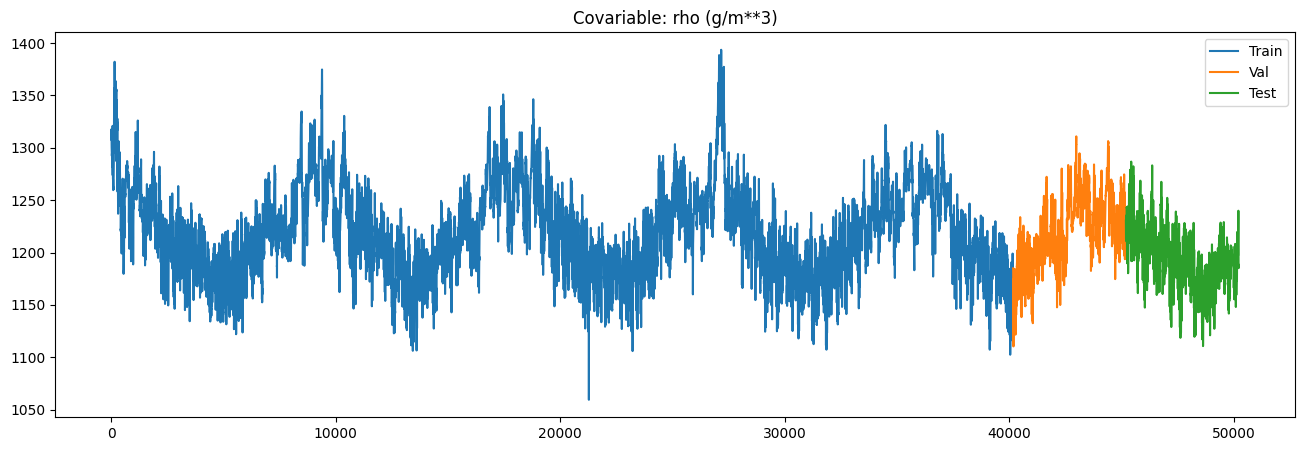

In [185]:
covar = 10 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [186]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [187]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (40154, 24, 17), y_tr: (40154, 1, 1)
Set de validación - x_vl: (4997, 24, 17), y_vl: (4997, 1, 1)
Set de prueba - x_ts: (4998, 24, 17), y_ts: (4998, 1, 1)


###7.3 Escalamiento

Esta etapa es idéntica a la implementada en el modelo anterior (multivariado-unistep).

Sin embargo **es importante tener en cuenta que NO escalaremos las columnas que contienen las variables temporales (pues ya están en el rango de -1 a 1).

Así que es necesario modificar ligeramente la función que realiza el escalamiento:

In [188]:
for i, col in enumerate(tr.columns):
    print(i,col)

0 p (mbar)
1 T (degC)
2 Tpot (K)
3 Tdew (degC)
4 rh (%)
5 VPmax (mbar)
6 VPact (mbar)
7 VPdef (mbar)
8 sh (g/kg)
9 H2OC (mmol/mol)
10 rho (g/m**3)
11 dia_sin
12 dia_cos
13 year_sin
14 year_cos
15 Wx
16 Wy


In [189]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # *************************************************
    # Escalamiento Xs: porción de código modificada para no escalar las
    # columnas con las variables temporales (columnas 11->14)
    # *************************************************
    FEAT_IDS = list(range(11)) + list(range(15,17)) # Columnas 0->10 + 15-16
    for i in FEAT_IDS:
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # *************************************************
    # Y dejar las columnas con variables temporales (13->16) intactas
    # *************************************************
    FEATS_TIME = list(range(11,15)) # Columnas 11-14
    x_tr_s[:,:,FEATS_TIME] = x_tr[:,:,FEATS_TIME]
    x_vl_s[:,:,FEATS_TIME] = x_vl[:,:,FEATS_TIME]
    x_ts_s[:,:,FEATS_TIME] = x_ts[:,:,FEATS_TIME]


    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [190]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'T (degC)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

#8. Creación y entrenamiento del modelo

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 17)
- Salidas: arreglos *y* (batches x output-length x features = batches x 4 x 1)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [202]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 17 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 120 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/120
157/157 - 3s - loss: 0.1332 - val_loss: 0.1156 - 3s/epoch - 20ms/step
Epoch 2/120
157/157 - 1s - loss: 0.1133 - val_loss: 0.1060 - 871ms/epoch - 6ms/step
Epoch 3/120
157/157 - 1s - loss: 0.1101 - val_loss: 0.1077 - 914ms/epoch - 6ms/step
Epoch 4/120
157/157 - 1s - loss: 0.1093 - val_loss: 0.1037 - 1s/epoch - 7ms/step
Epoch 5/120
157/157 - 1s - loss: 0.1086 - val_loss: 0.1046 - 905ms/epoch - 6ms/step
Epoch 6/120
157/157 - 1s - loss: 0.1082 - val_loss: 0.1040 - 872ms/epoch - 6ms/step
Epoch 7/120
157/157 - 1s - loss: 0.1079 - val_loss: 0.1043 - 887ms/epoch - 6ms/step
Epoch 8/120
157/157 - 1s - loss: 0.1076 - val_loss: 0.1035 - 706ms/epoch - 4ms/step
Epoch 9/120
157/157 - 1s - loss: 0.1074 - val_loss: 0.1032 - 689ms/epoch - 4ms/step
Epoch 10/120
157/157 - 1s - loss: 0.1071 - val_loss: 0.1045 - 667ms/epoch - 4ms/step
Epoch 11/120
157/157 - 1s - loss: 0.1070 - val_loss: 0.1041 - 688ms/epoch - 4ms/step
Epoch 12/120
157/157 - 1s - loss: 0.1067 - val_loss: 0.1062 - 662ms/epoch - 4ms

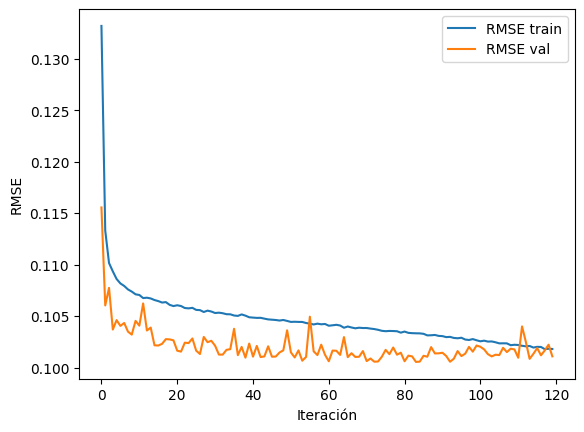

In [203]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

**Observaciones y sugerencias:**

- Al incluir las variables temporales obtenemos un RMSE ligeramente inferior al del tutorial anterior (0.118 vs. 0.120)
- En todo caso es importante tener en cuenta que se sugiere afinar los hiperparámetros de cada modelo para poder realizar comparaciones concluyentes.
- Al igual que en el caso del modelo multivariado-unistep en este caso, además de la afinación de hiperparámetros, se sugierer realizar un análisis de *feature importances* para determinar las covariables más relevantes en la predicción.

De nuevo, en la afinación se deberían considerar los siguientes hiperparámetros:
- *INPUT_LENGTH* y *OUTPUT_LENGTH* (esto implica modificar la fase de pre-procesamiento)
- Número de unidades de la Red LSTM
- Pérdida
- Tasa de aprendizaje
- Epochs
- Batch size

## 9. Desempeño del modelo

Suponiendo que el modelo ya ha sido afinado y entrenado, verificaremos su desempeño para el set de prueba y lo compararemos con el desempeño obtenido con los sets de entrenamiento y validación:

In [204]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.098
  RMSE val:	 0.099
  RMSE test:	 0.106


Al igual que hicimos con el modelo univariado-multistep analicemos los errores (RMSEs) individuales para cada una de las horas predichas, para lo cual:

1. Generaremos las predicciones sobre la totalidad del set de prueba con el modelo entrenado.
2. Calcularemos y graficaremos el RMSE para cada instante de tiempo predicho

In [205]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # BATCHESx4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4
'''
# Graficar rmse para cada timestep
t = np.linspace(1,4,4)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid();
'''

"\n# Graficar rmse para cada timestep\nt = np.linspace(1,4,4)\n\nfig, ax = plt.subplots()\nax.scatter(t,rmse)\nax.set_xlabel('Hora predicha')\nax.set_ylabel('Error RMSE (°C)')\nplt.xticks(ticks=t, labels=t)\nplt.grid();\n"

Y al igual que ocurría con el modelo multivariado-multistep, vemos que en este caso el RMSE se incrementa a medida que nos movemos más hacia adelante en las predicciones.

De nuevo esto es un resultado preliminar y se sugiere afinar los hiperparámetros y realizar un análisis de *feature importances* para intentar mejorar este desempeño.

##10. Predicciones con el modelo entrenado

Suponiendo que el modelo ya ha sido afinado, podemos ponerlo a prueba con el set *test*.

Usaremos la misma función `predecir` usada en los videos anteriores:

In [206]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [207]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

Analicemos este desempeño gráficamente mostrando las temperaturas originales y las predichas por el modelo para cada uno de los datos en el set de prueba:

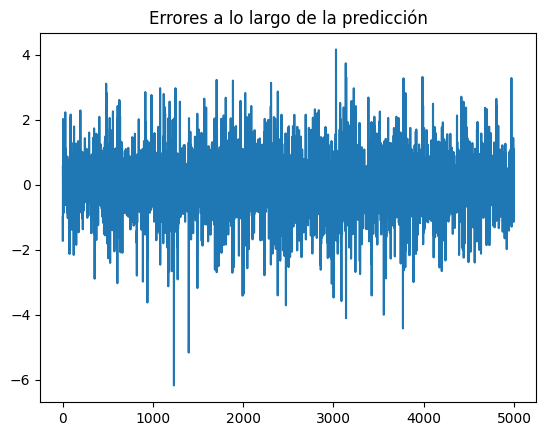

In [208]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred.flatten()
plt.title('Errores a lo largo de la predicción')
plt.plot(errores);

Se observa que:

- El promedio de errores es cercano a cero
- Pero en algunos instantes de tiempo se alcanzan errores extremos de hasta -6 y +5 grados.

Estos errores se podrían reducir al hacer una afinación del modelo o modificando el enfoque de predicción.

## 11. Conclusiones y sugerencias

- Hemos entrenado un cuarto modelo multivariado + multistep **incluyendo además la codificación de las variables temporales**
- Para intentar mejorar el desempeño del modelo se sugiere afinar sus hiperparámetros y realizar un análisis de *feature importances*.

En el próximo tutorial veremos cómo realizar el análisis de importancia de características a partir del modelo que acabamos de entrenar.

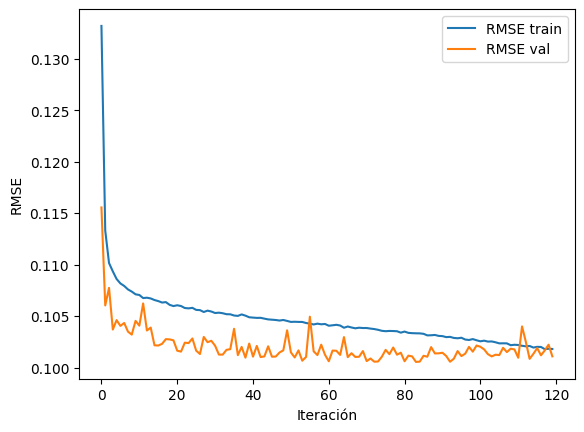

In [209]:
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

Last Model 


Columnas: Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'dia_sin', 'dia_cos', 'year_sin',
       'year_cos', 'Wx', 'Wy'],
      dtype='object') 
 
Tamaño set de entrenamiento: (40179, 17)
Tamaño set de validación: (5022, 17)
Tamaño set de prueba: (5023, 17) 
 
INPUT_LENGTH 	 Tamaño de la secuencia de entrenamiento: 	 24
OUTPUT_LENGTH 	 Tamaño del resultado de la secuencia: 	 	 1
N_UNITS 	 Tamaño de la memoria de la red neurolnal: 	 128
EPOCHS 		 Cantidad de veces que el modelo se corrije: 	 120
BATCH_SIZE 	 Cantidad muestras para cada iteracion: 	 256 


Comparativo desempeños:
  RMSE train:	 0.098
  RMSE val:	 0.099
  RMSE test:	 0.106 




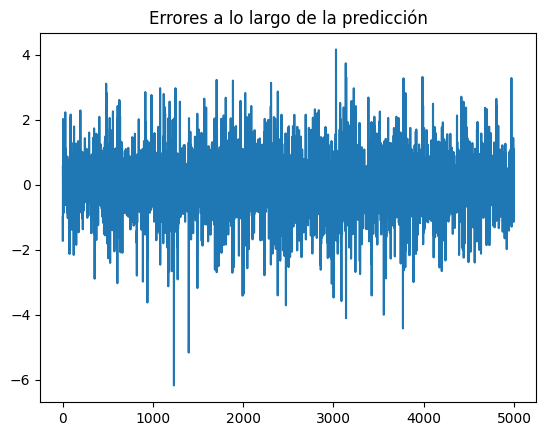

In [210]:
# Parametros del primer modelo
print(f'Last Model \n\n')
print(f'Columnas: {df.columns} \n ')
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape} \n ')
print(f'INPUT_LENGTH \t Tamaño de la secuencia de entrenamiento: \t {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH \t Tamaño del resultado de la secuencia: \t \t {OUTPUT_LENGTH}')
print(f'N_UNITS \t Tamaño de la memoria de la red neurolnal: \t {N_UNITS}')
print(f'EPOCHS \t\t Cantidad de veces que el modelo se corrije: \t {EPOCHS}')
print(f'BATCH_SIZE \t Cantidad muestras para cada iteracion: \t {BATCH_SIZE} \n\n')
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f} \n\n')



plt.title('Errores a lo largo de la predicción')
plt.plot(errores)


In [211]:
%%capture cap --no-stderr
# Parametros del primer modelo
print(f'Modelo B2 \n\n')
print(f'Columnas: {df.columns} \n ')
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape} \n ')
print(f'INPUT_LENGTH \t Tamaño de la secuencia de entrenamiento: \t {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH \t Tamaño del resultado de la secuencia: \t \t {OUTPUT_LENGTH}')
print(f'N_UNITS \t Tamaño de la memoria de la red neurolnal: \t {N_UNITS}')
print(f'EPOCHS \t\t Cantidad de veces que el modelo se corrije: \t {EPOCHS}')
print(f'BATCH_SIZE \t Cantidad muestras para cada iteracion: \t {BATCH_SIZE} \n\n')
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f} \n\n')


In [212]:
with open('modeloB2.txt', 'w') as f:
    f.write(cap.stdout)